### Steps in the codes
Predicting house prices from the dataset at https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

1. Importing necessary libraries 
2. Importing data and Cleaning data 
    - dropping na values
    - dropping unnecessary features
    - converting sqft to a single value
    
3. Feature Engineering
    - adding new feature bhk
    - adding new feature price per sqft
    - dimensionality reduction , locations less than 10 datapoints neglected
    - outlier removal using business logic, removing 3bhk with area of less than that of 2bhk
    - outlier removal using standard deviatoin
    - outlier removal using bathroom feature
    - one hot encoding for location
4. Building Model using Linear Regression
5. Use K Fold cross valiadation to measeure accuracy of Linear Model
6. Find best model using GridSearchCV
7. Model Testing
8. Export the tested model to a pickle file
9. Export location and column information to a file that will be useful later on in our prediction application

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [2]:
df1= pd.read_csv('bengaluru_house_prices.csv')
df1.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.columns


Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [6]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

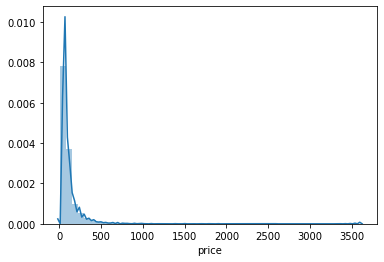

In [7]:
sns.distplot(df1['price'])

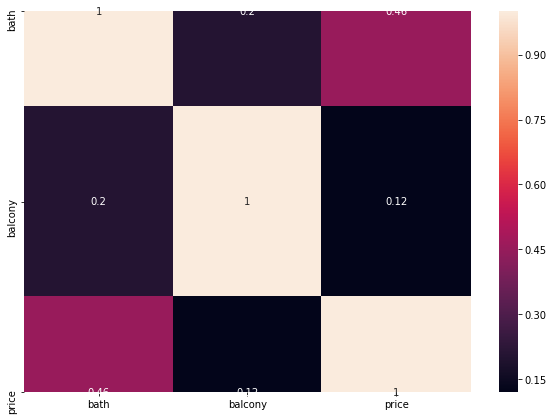

In [8]:
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(df1.corr(),annot = True)


#### Drop feautures not included in the model

In [9]:
df2= df1.drop(['area_type','society','availability','balcony'],axis='columns')
df2.shape

(13320, 5)

### Data Cleaning : NA values

In [10]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [11]:
df3=df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df3.shape

(13246, 5)

### Feature Engineering

#### Adding new feature (integer) for bhk and putting same name for everthing

In [13]:
df3['bhk']= df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

E:\Coding\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

#### Explore total_sqft feature

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [15]:
df3[~df3['total_sqft'].apply(is_float)].head(5)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


#### Taking mean of the range of sqft range as total sqft

In [16]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [17]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(5)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


### Adding new feature price per sqft

In [18]:
df4['price_per_sqft']=df4['price']/df4['total_sqft']
df4.head(5)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,0.036998
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,0.046154
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,0.043056
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,0.062459
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,0.042500


In [19]:
df4.price_per_sqft.describe()

count    13200.000000
mean         0.079208
std          1.067272
min          0.002678
25%          0.042677
50%          0.054383
75%          0.073171
max        120.000000
Name: price_per_sqft, dtype: float64

### Dimensionality Reduction

Putting all location less than 10 apartments into other category


In [20]:
df4.location.value_counts()

Whitefield                      532
Sarjapur  Road                  392
Electronic City                 302
Kanakpura Road                  264
Thanisandra                     232
                               ... 
4th Block HBR Layout              1
V.V Puram                         1
2nd phase jp nagar, jp nagar      1
Behind Don Bosco Church           1
Electronic city phase 1,          1
Name: location, Length: 1298, dtype: int64

In [21]:
len(df4.location.unique())

1298

In [22]:
df5=df4
df5['location']=df5.location.apply(lambda x: x.strip())
loc=df5['location'].value_counts(ascending=False)
loc

Whitefield           533
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       264
Thanisandra          235
                    ... 
K G Colony             1
Gokaula Extension      1
Subramanyanagar        1
Ashraya Layout         1
Halanayakanahalli      1
Name: location, Length: 1287, dtype: int64

In [23]:
len(loc)

1287

In [24]:
len(loc[loc>10])

240

In [25]:
loc_less_than10 = loc[loc<10]

In [26]:
df5.location = df5.location.apply(lambda x: 'other' if x in loc_less_than10 else x)
len(df5.location.unique())

255

### Removing outliers

--Deleting apartments with sqft area less than 300sqft for a bedroom

-Deleting 1bh with price more than 2bhk

-Deleting 2bhk with price more than 3bhk

-Deleting apartments with more than n+2 bathrooms for n bedrooms

#####  --Deleting apartments with sqft area less than 300sqft for a bedroom


In [27]:
df5[df5.total_sqft/df5.bhk<300].head()


,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,0.362745
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,0.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,0.106610
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,0.062963
70,other,3 Bedroom,500.0,3.0,100.0,3,0.200000


In [28]:
len(df5[df5.total_sqft/df5.bhk<300])

744

In [29]:
df6=df5[~(df5.total_sqft/df5.bhk<300)]
df6.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,0.036998
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,0.046154
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,0.043056
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,0.062459
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,0.042500


#### Outlier removal using  Mean and Standard Deviation

In [30]:
df6.price_per_sqft.describe()


count    12456.000000
mean         0.063085
std          0.041681
min          0.002678
25%          0.042105
50%          0.052941
75%          0.069167
max          1.764706
Name: price_per_sqft, dtype: float64

In [31]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10222, 7)

#### Remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment



In [32]:

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7369, 7)

Text(0, 0.5, 'Count')

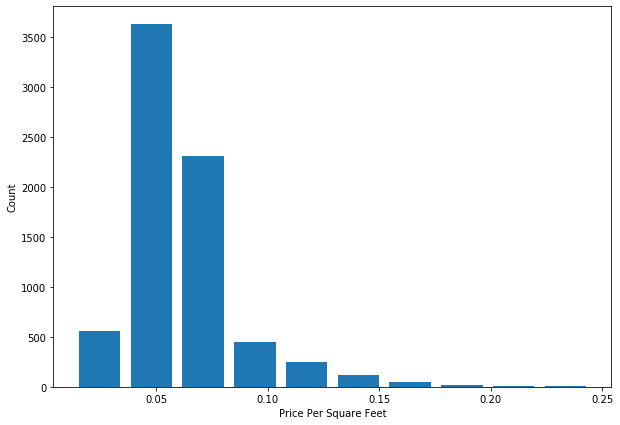

In [33]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (10,7)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

#### Outlier Removal Using Bathrooms Feature


In [34]:
df8.bath.unique()


array([ 4.,  3.,  2.,  5.,  8.,  1.,  6., 14.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

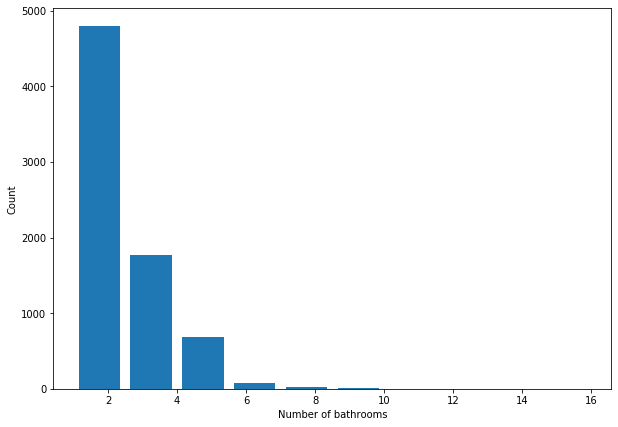

In [35]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [36]:
df8[df8.bath>df8.bhk+2]


,location,size,total_sqft,bath,price,bhk,price_per_sqft
585,BTM 1st Stage,9 Bedroom,3300.0,14.0,500.0,9,0.151515
1642,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,0.032520
5305,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,0.064286
6792,Thanisandra,3 BHK,1806.0,6.0,116.0,3,0.064230
8476,other,6 BHK,11338.0,9.0,1000.0,6,0.088199


#### Deleting apartments with more bathrooms than n+2, where n= room

In [37]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape


(7291, 7)

#### Delting size and price per aqft feature

In [38]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


#### Use One Hot Encoding For Location


In [39]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:

df12 = df11.drop('location',axis='columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Building Linear Regression Model

In [42]:
df12.shape

(7291, 258)

In [43]:
X=df12.drop(['price'],axis='columns')

In [44]:
y=df12.price

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [46]:
len(X_train)


5832

In [47]:
len(X_test)

1459

In [48]:
len(y_train)

5832

In [49]:
len(y_test)

1459

In [50]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8556662450161991

### K Fold cross validation to measure accuracy of our LinearRegression model

In [51]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84196276, 0.82904236, 0.90136194, 0.85131228, 0.84354632])

## Exporting Model to a pickle file

In [ ]:
#!pip install pickle5

In [53]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr,f)

In [54]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))